## Use full data from Odyssey

In [891]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [884]:
binfile = '/mnt/store1/oliverphilcox/PowerSpectra/k_binning2.csv'
counts_dir = '/mnt/store1/oliverphilcox/PowerQPM_New/R0_50/'
#counts_dir1 = '/mnt/store1/oliverphilcox/PowerQPM50/'
#counts_dir2 = '/mnt/store1/oliverphilcox/PowerQPM50_noPhi/'
n = 19
l = 4
m = l//2+1

### Load in counts

In [885]:
k_bins = np.loadtxt(binfile).mean(axis=1)
all_k = np.loadtxt(binfile)

In [259]:
RR = np.zeros([n,m])
index = 0
while True:
    filename = counts_dir+'RR_%d_power_counts_n%d_m%d_full.txt'%(index,n,m)
    if not os.path.exists(filename):
        break
    RR+=np.loadtxt(filename)
    index+=1

In [260]:
DD = np.loadtxt(counts_dir+'DD_mock_0001_power_counts_n%d_m%d_full.txt'%(n,m))
DR = np.loadtxt(counts_dir+'DR_mock_0001_power_counts_n%d_m%d_full.txt'%(n,m))

In [261]:
### count number of random particles
rand_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_randoms_50x.xyzwj'
with open(rand_par) as infile:
    for l,line in enumerate(infile):
        pass
N_rand = l+1

In [262]:
### count number of galaxies
gal_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_galaxy_1.xyzwj'
with open(gal_par) as infile:
    for l,line in enumerate(infile):
        pass
N_gal=l+1

In [263]:
### count number of randoms
index = 0.
RR_pairs = 0.
while True:
    this_rand_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_randoms_50x_%d'%index
    if not os.path.exists(this_rand_par):
        break
    with open(this_rand_par) as infile:
        for l,line in enumerate(infile):
            pass
    RR_pairs+=(l+1)*l
    index+=1

In [264]:
DR_pairs = N_gal*N_rand
DD_pairs = N_gal*(N_gal-1)

In [265]:
norm = 0
with open(gal_par) as infile:
    for l,line in enumerate(infile):
        this_w = float(line.split()[3])
        norm+=this_w**2.*(1./this_w-1.)/20000
print("Norm = %.2f"%norm)

Norm = 4.25


In [266]:
### compute power
power = (DD-2.*DR/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm
#power_noPhi = (DDnoPhi-2.*DRnoPhi/(DR_pairs/DD_pairs)+RRnoPhi/(RR_pairs/DD_pairs))/(norm*N_gal/N_rand)

In [267]:
all_DD=[]
all_DR=[]
good_mocks=[]
n_mocks=0
for mock_int in range(1,101):
    mock_no = str(mock_int).zfill(4)
    if os.path.exists(counts_dir+'DD_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m)):
        if os.path.exists(counts_dir+'DR_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m)):
            tDD = np.loadtxt(counts_dir+'DD_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m))
            tDR = np.loadtxt(counts_dir+'DR_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m))
            all_DD.append(tDD)
            all_DR.append(tDR)
            n_mocks+=1
            good_mocks.append(mock_no)

In [268]:
len(good_mocks)

93

In [269]:
### count number of galaxies in each file
N_gal_all=[]
norm_all=[]
for mock_no in good_mocks:
    ### count number of galaxies
    gal_par = '/mnt/store1/oliverphilcox/QPM_proc/qpm_galaxy_%s.xyzw'%mock_no
    this_norm=0.
    with open(gal_par) as infile:
        for l,line in enumerate(infile):
            this_w = float(line.split()[3])
            this_norm+=this_w**2.*(1./this_w-1.)/20000
    N_gal_all.append(l+1)
    norm_all.append(this_norm)

In [270]:
all_power = []
pow_mean,pow_std = [np.zeros([n,m]) for _ in range(2)]
for i in range(n_mocks):
    all_power.append((all_DD[i]-2.*all_DR[i]/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm_all[i])
for i in range(n):
    for j in range(m):
        pow_mean[i,j] = np.mean([all_power[ind][i,j] for ind in range(n_mocks)])
        pow_std[i,j] = np.std([all_power[ind][i,j] for ind in range(n_mocks)])

#### Load R0=100 power

In [271]:
power100 = np.load('R0_100_power.npy')

#### Load no Phi power

In [272]:
power50_noPhi = np.load('R0_50_no_phi_power.npy')
power100_noPhi = np.load('R0_100_no_phi_power.npy')

#### Define Covariance

In [676]:
power_ravel = np.asarray([pp.reshape(n,m).T.ravel() for pp in all_power])
qpm_cov = np.zeros([len(all_power[0].ravel()),len(all_power[0].ravel())])
power_mean = power_ravel.mean(axis=0)
for i in range(len(good_mocks)):
    tmp = all_power[i].T.ravel().reshape(-1,1)-power_mean.reshape(-1,1)
    qpm_cov+=np.matmul(tmp,tmp.T)
qpm_cov/=len(good_mocks)-1

In [677]:
qpm_std = (np.diag(qpm_cov)**0.5).reshape(m,n).T

#### Load R0=100 Covariance

In [678]:
qpm_cov100 = np.load('R0_100_cov.npy')
qpm_std100 = (np.diag(qpm_cov100)**0.5).reshape(m,n).T

#### Load CAMB model

In [679]:
camb_dir = np.load('/mnt/store1/oliverphilcox/PowerSpectra/CAMB_power_QPM.npz')
camb_k_all = camb_dir['k']
camb_k = camb_k_all[camb_k_all>0.01]
camb_Pk = camb_dir['linear_power'][camb_k_all>0.01]
camb_Pk_NL = camb_dir['non_linear_power'][camb_k_all>0.01]


from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log10(camb_k),np.log10(camb_Pk))
spl_NL = UnivariateSpline(np.log10(camb_k),np.log10(camb_Pk_NL))

f = 0.774 # kaiser power
b = 2 # bias
beta = f/b

def camb_model(k,ell):
    lin_pow = 10.**spl(np.log10(k))
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")
        
def FoG_model(k,ell):
    lin_pow = 10.**spl(np.log10(k))
    
    if ell==0:
        return b**2*lin_pow*(k*beta*Sigma*(-3*beta+k**2.*(6+beta)*Sigma**2)+3*(beta-k**2*Sigma**2)**2*np.arctan(k*Sigma))/(3*k**5*Sigma**5)
    elif ell==2:
        return b**2*lin_pow*(45*k*beta**2*Sigma-90*k**3*beta*Sigma**3+k**5*(45+4*beta**2)*Sigma**5-15*(beta-k**2*Sigma**2)**2*(3+k**2*Sigma**2)*np.arctan(k*Sigma))/(6*k**7*Sigma**7)
    elif ell==4:
        x = k*Sigma
        
        return (3*b**2*lin_pow*(beta-x**2)**2*(-5*x*(21+11*x**2)+3*(35+30*x**2+3*x**4)*np.arctan(x)))/(8*x**9)

In [716]:
def FoG_k_mu_power(mu,k=0,Sigma=0.4,NL=False,exp=False):
    if NL:
        this_pow = 10.**spl_NL(np.log10(k))
    else:
        this_pow = 10.**spl(np.log10(k))
    if exp:
        FoG_factor = np.exp(-(k*mu*Sigma)**2)
    else:
        FoG_factor = 1./(1.+(k*mu*Sigma)**2)
    return this_pow*b**2*(1+beta*mu**2)**2 *FoG_factor

from scipy.special import legendre
from scipy.integrate import quad
def FoG_multipole(ell,k,Sigma=Sigma,NL=False,exp=False):
    return quad(lambda mu: FoG_k_mu_power(mu,k=k,Sigma=Sigma,NL=NL,exp=exp)*legendre(ell)(mu),-1,1)[0]*(2.*ell+1)*0.5

In [835]:
def no_FoG_multipole_analyt(ell,k,beta=beta,b=b,NL=False):
    if NL:
        this_pow = 10.**spl_NL(np.log10(k))
    else:
        this_pow = 10.**spl(np.log10(k))
    if ell==0:
        return this_pow*b**2*(1+2*beta/3+beta**2/5)
    elif ell==2:
        return this_pow*b**2*4./21.*beta*(7.+3*beta)
    elif ell==4:
        return this_pow*b**2*8*beta**2/35
def FoG_multipole_analyt(ell,k,sigma=1,beta=beta,b=b,NL=False):
    """ Using expression from Percival/White09 with Eq.21 with Lorentzian FoG.
    Calculations done in Mathematica (or 1610.07785.)"""
    if NL:
        this_pow = 10.**spl_NL(np.log10(k))
    else:
        this_pow = 10.**spl(np.log10(k))
    if ell==0:
        return this_pow*b**2*(beta*k*sigma*(-3*beta + (6 + beta)*k**2*sigma**2) + 3*(beta - k**2*sigma**2)**2*np.arctan(k*sigma))/(3.*k**5*sigma**5)
    if ell==2:
        return this_pow*b**2*(45*beta**2*k*sigma - 90*beta*k**3*sigma**3 + (45 + 4*beta**2)*k**5*sigma**5 - 15*(beta - k**2*sigma**2)**2*(3 + k**2*sigma**2)*np.arctan(k*sigma))/(6.*k**7*sigma**7)
    if ell==4:
        return this_pow*b**2*(3*(beta - k**2*sigma**2)**2*(-5*k*sigma*(21 + 11*k**2*sigma**2) + 3*(35 + 30*k**2*sigma**2 + 3*k**4*sigma**4)*np.arctan(k*sigma)))/(8.*k**9*sigma**9)

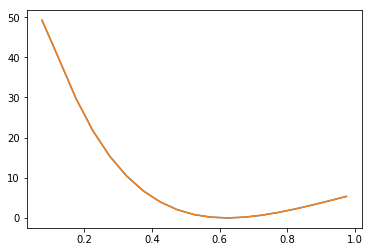

In [737]:
plt.plot(k_bins,FoG_multipole_analyt(4,k_bins,sigma=1.)*k_bins)
FoG1 = np.asarray([FoG_multipole(4,kk,1.) for kk in k_bins])
plt.plot(k_bins,FoG1*k_bins)

In [687]:
def FoG_k_mu_power(mu,k=0,Sigma=0.4,NL=False,exp=False):
    if NL:
        this_pow = 10.**spl_NL(np.log10(k))
    else:
        this_pow = 10.**spl(np.log10(k))
    if exp:
        FoG_factor = np.exp(-(k*mu*f*Sigma)**2)
    else:
        FoG_factor = 1./(1.+(k*mu*f*Sigma)**2)
    return this_pow*(b**2+2*mu**2*b*f+mu**4*f**2)*FoG_factor

from scipy.special import legendre
from scipy.integrate import quad
def FoG_multipole(ell,k,Sigma=Sigma,NL=False,exp=False):
    return quad(lambda mu: FoG_k_mu_power(mu,k=k,Sigma=Sigma,NL=NL,exp=exp)*legendre(ell)(mu),0,1)[0]*(2.*ell+1)

## Plots

Using 10x errors


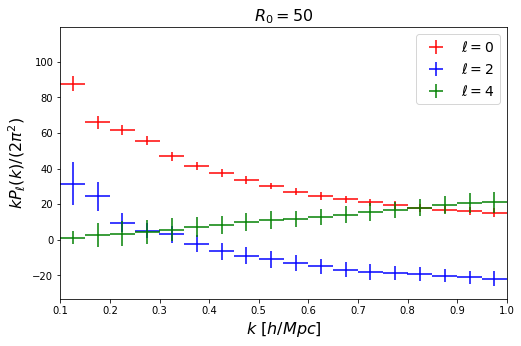

In [289]:
plt.figure(figsize=(8,5))
plt.errorbar(k_bins,k_bins*power[:,0]/(2*np.pi**2),k_bins*qpm_std[:,0]/(2.*np.pi**2.)*10,0.025,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,k_bins*power[:,1]/(2.*np.pi**2.),k_bins*qpm_std[:,1]/(2.*np.pi**2.)*10,0.025,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,k_bins*power[:,2]/(2.*np.pi**2.),k_bins*qpm_std[:,2]/(2.*np.pi**2.)*10,0.025,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$kP_\ell(k)/(2\pi^2)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
plt.legend(fontsize=14);
plt.title(r'$R_0=50$',fontsize=16);
print('Using 10x errors')

Using 10x errors


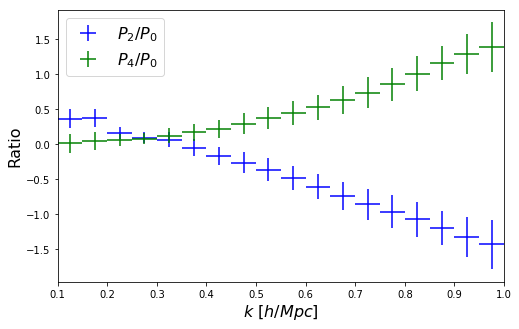

In [109]:
plt.figure(figsize=(8,5))
quad_ratio = power[:,1]/power[:,0]
hex_ratio = power[:,2]/power[:,0]
quad_err = quad_ratio*np.sqrt((qpm_std[:,0]/power[:,0])**2.+(qpm_std[:,1]/power[:,1])**2.)
hex_err = quad_ratio*np.sqrt((qpm_std[:,0]/power[:,0])**2.+(qpm_std[:,1]/power[:,1])**2.)
plt.errorbar(k_bins,quad_ratio,quad_err*10,0.025,marker='',ls='',c='b',label=r'$P_2/P_0$')
plt.errorbar(k_bins,hex_ratio,10*hex_err,0.025,marker='',ls='',c='g',label=r'$P_4/P_0$')
plt.ylabel(r'Ratio',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
#plt.yscale('log')
plt.legend(fontsize=16);
print("Using 10x errors")

## Plot both $R_0=50$ (points) and $R_0=100$ (lines)

Using 10x errors


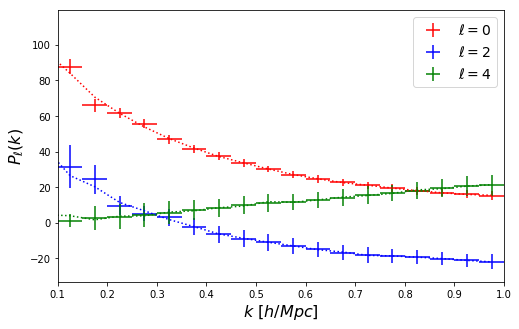

In [291]:
plt.figure(figsize=(8,5))
f=k_bins/(2.*np.pi**2.)
plt.errorbar(k_bins,f*power[:,0],f*qpm_std[:,0]*10,0.025,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,f*power100[:,0],marker='',ls=':',c='r')
plt.errorbar(k_bins,f*power[:,1],f*qpm_std[:,1]*10,0.025,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,f*power100[:,1],marker='',ls=':',c='b')
plt.errorbar(k_bins,f*power[:,2],f*qpm_std[:,2]*10,0.025,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.errorbar(k_bins,f*power100[:,2],marker='',ls=':',c='g')
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
plt.legend(fontsize=14);
print('Using 10x errors')

## Plot Ratio

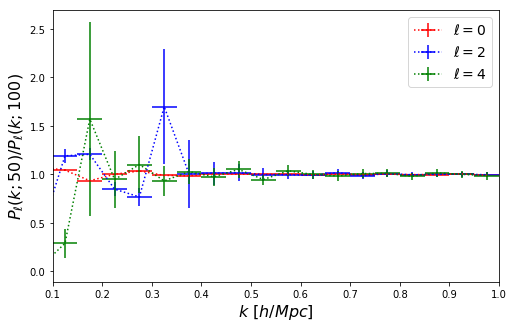

In [294]:
plt.figure(figsize=(8,5))
err_tot = np.sqrt((qpm_std/power)**2.+(qpm_std100/power100)**2.)*power/power100
plt.errorbar(k_bins,power[:,0]/power100[:,0],err_tot[:,0],0.025,
             marker='',ls=':',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1]/power100[:,1],err_tot[:,1],0.025,
             marker='',ls=':',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2]/power100[:,2],err_tot[:,2],0.025,
             marker='',ls=':',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k;50)/P_\ell(k;100)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
plt.legend(fontsize=14);

## Plot Power without Survey Correction Function $\Phi$

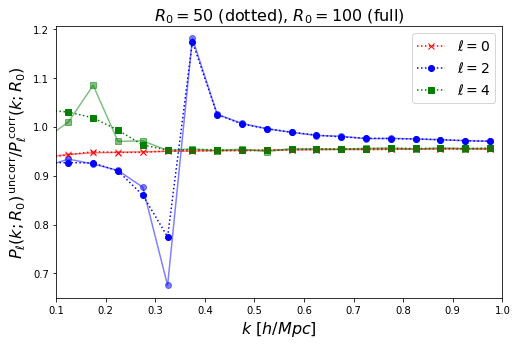

In [295]:
plt.figure(figsize=(8,5))
plt.errorbar(k_bins,power50_noPhi[:,0]/power[:,0],marker='x',ls=':',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power50_noPhi[:,1]/power[:,1],marker='o',ls=':',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power50_noPhi[:,2]/power[:,2],marker='s',ls=':',c='g',label=r'$\ell = 4$')
plt.errorbar(k_bins,power100_noPhi[:,0]/power100[:,0],marker='x',ls='-',c='r',alpha=0.5)
plt.errorbar(k_bins,power100_noPhi[:,1]/power100[:,1],marker='o',ls='-',c='b',alpha=0.5)
plt.errorbar(k_bins,power100_noPhi[:,2]/power100[:,2],marker='s',ls='-',c='g',alpha=0.5)

plt.ylabel(r'$P_\ell(k;R_0)^\mathrm{\,uncorr}/P_\ell^\mathrm{\,corr}(k;R_0)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
plt.legend(fontsize=14);
plt.title(r'$R_0 = 50$ (dotted), $R_0=100$ (full)',fontsize=16);

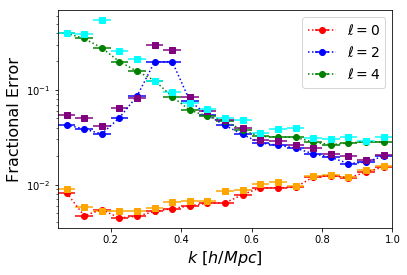

In [890]:
x=np.abs(qpm_std/pow_mean)
x100=np.abs(qpm_std100/power100)
plt.errorbar(k_bins,x[:,0],None,0.025,c='r',label=r'$\ell = 0$',ls=':',marker='o')
plt.errorbar(k_bins,x[:,1],None,0.025,c='b',label=r'$\ell = 2$',ls=':',marker='o')
plt.errorbar(k_bins,x[:,2],None,0.025,c='g',label=r'$\ell = 4$',ls=':',marker='o')
plt.errorbar(k_bins,x100[:,0],None,0.025,c='orange',ls='',marker='s')
plt.errorbar(k_bins,x100[:,1],None,0.025,c='purple',ls='',marker='s')
plt.errorbar(k_bins,x100[:,2],None,0.025,c='cyan',ls='',marker='s')
plt.yscale('log');
plt.xlim([0.05,1.])
plt.legend(fontsize=14);
plt.ylabel('Fractional Error',fontsize=16);
plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16);

### Compare to CAMB Kaiser + FoG model

In [840]:
def diff(pars):
    sigma0,beta0,b0=pars
    mod_pow = FoG_multipole_analyt(0,k_bins,sigma0,beta0,b0,True)
    mod_pow2 = FoG_multipole_analyt(2,k_bins,sigma0,beta0,b0,True)
    mod_pow4 = FoG_multipole_analyt(4,k_bins,sigma0,beta0,b0,True)
    out=np.sum(0.5*((mod_pow-power[:,0])/qpm_std[:,0])**2)
    out+=np.sum(0.5*((mod_pow2-power[:,1])/qpm_std[:,1])**2)
    out+=np.sum(0.5*((mod_pow4-power[:,2])/qpm_std[:,2])**2)
    return out
from scipy.optimize import minimize
out=minimize(diff,[4.,beta,b])

In [841]:
def diff_no_FoG(pars):
    beta0,b0=pars
    mod_pow = no_FoG_multipole_analyt(0,k_bins,beta0,b0,True)
    mod_pow2 = no_FoG_multipole_analyt(2,k_bins,beta0,b0,True)
    mod_pow4 = no_FoG_multipole_analyt(4,k_bins,beta0,b0,True)
    out=np.sum(0.5*((mod_pow-power[:,0])/qpm_std[:,0])**2)
    out+=np.sum(0.5*((mod_pow2-power[:,1])/qpm_std[:,1])**2)
    out+=np.sum(0.5*((mod_pow4-power[:,2])/qpm_std[:,2])**2)
    return out
from scipy.optimize import minimize
out2=minimize(diff_no_FoG,[beta,b])

In [842]:
opt_pars = out.x
print(opt_pars)
opt_sigma,opt_beta,opt_b = opt_pars

opt_pars2 = out2.x
print(opt_pars2)
opt_beta2,opt_b2 = opt_pars2

[3.33975213 0.37517131 1.97232297]
[-0.19423657  1.83341238]


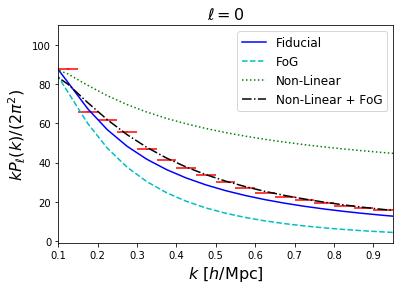

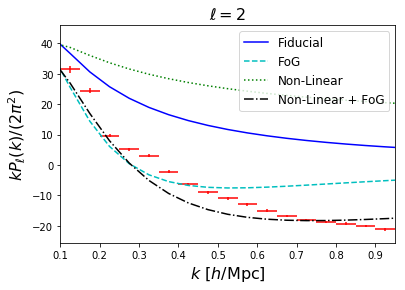

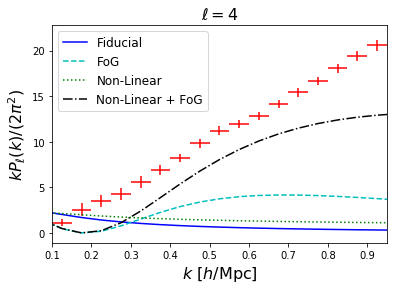

In [845]:
for m in range(3):
    plt.figure()
    
    model_power_NL = no_FoG_multipole_analyt(m*2,k_bins,opt_beta,opt_b,True)
    model_power_NL_FoG = FoG_multipole_analyt(m*2,k_bins,opt_sigma,opt_beta,opt_b,True)
    model_power = no_FoG_multipole_analyt(m*2,k_bins,opt_beta,opt_b,False)
    model_power_FoG = FoG_multipole_analyt(m*2,k_bins,opt_sigma,opt_beta,opt_b,False)

    plt.errorbar(k_bins,k_bins*power[:,m]/(2.*np.pi**2),xerr=0.025,yerr=k_bins*pow_std[:,m]/(2.*np.pi**2),marker='',ls='',c='r')
    plt.errorbar(k_bins,k_bins*model_power/(2.*np.pi**2),ls='-',label='Fiducial',c='b')
    plt.errorbar(k_bins,k_bins*model_power_FoG/(2.*np.pi**2),ls='--',label='FoG',c='c')
    plt.errorbar(k_bins,k_bins*model_power_NL/(2.*np.pi**2),ls=':',label='Non-Linear',c='g')
    plt.errorbar(k_bins,k_bins*model_power_NL_FoG/(2.*np.pi**2),ls='-.',label='Non-Linear + FoG',c='k')

    plt.title(r'$\ell = %d$'%(m*2),fontsize=16)
    plt.ylabel(r'$kP_\ell(k)/(2\pi^2)$',fontsize=16);
    plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16);
    plt.legend(fontsize=12);
    plt.xlim([0.1,0.95])
    #plt.ylim([0.,100.]);

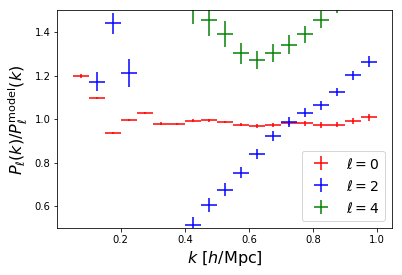

In [861]:
model_power0 = FoG_multipole_analyt(0,k_bins,opt_sigma,opt_beta,opt_b,True)
model_power2 = FoG_multipole_analyt(2,k_bins,opt_sigma,opt_beta,opt_b,True)
model_power4 = FoG_multipole_analyt(4,k_bins,opt_sigma,opt_beta,opt_b,True)

plt.errorbar(k_bins,power[:,0]/model_power0,xerr=0.025,
             yerr=pow_std[:,0]/model_power0,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1]/model_power2,xerr=0.025,
            yerr=pow_std[:,1]/model_power2,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2]/model_power4,xerr=0.025,
             yerr=pow_std[:,2]/model_power4,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k)/P_\ell^\mathrm{model}(k)$',fontsize=16);
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16);
plt.legend(fontsize=14);
#plt.xlim([0.1,.5])
plt.ylim([0.5,1.5]);

## Plot Covariance Matrix

In [862]:
k_all = np.concatenate([k_bins for _ in range(3)])
k_mat = np.matmul(k_all.reshape(-1,1),k_all.reshape(1,-1))

In [863]:
nk = len(k_bins)
k_med = k_bins
def k_plotter(mat,perc=99.9,title='',vmax=-10):
    if vmax==-10:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.gca().xaxis.tick_bottom()
    for i in range(m-1):
        plt.hlines(nk*(i+1),0,nk*m,linestyles='--',alpha=0.3);
        plt.vlines(nk*(i+1),0,nk*m,linestyles='--',alpha=0.3);
    for i in range(m):
        for j in range(m):
            plt.text((i+0.1)*nk,(j+0.9)*nk,'%d%d'%(2*i,2*j),alpha=0.7)
    if len(title)>0:
        plt.title(title,fontsize=16)
    plt.colorbar();    
    plt.ylim([m*nk,0])
    plt.xlim([0,m*nk])
    ticks = np.concatenate([["%.2f"%(min(k_med)),"%.2f"%(k_med[len(k_med)//2])] for _ in range(m)])
    plt.xticks(np.arange(0,(nk+0.5)*m,nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
    plt.yticks(np.arange(0,(nk+0.5)*m,nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
    plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=14)
    plt.ylabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=14)

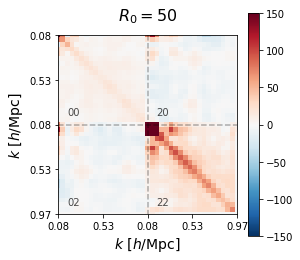

In [864]:
k_plotter(qpm_cov*k_mat,title=r'$R_0=50$',vmax=150);

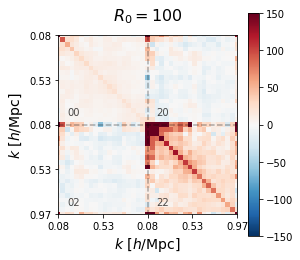

In [865]:
k_plotter(qpm_cov100*k_mat,title=r'$R_0=100$',vmax=150);

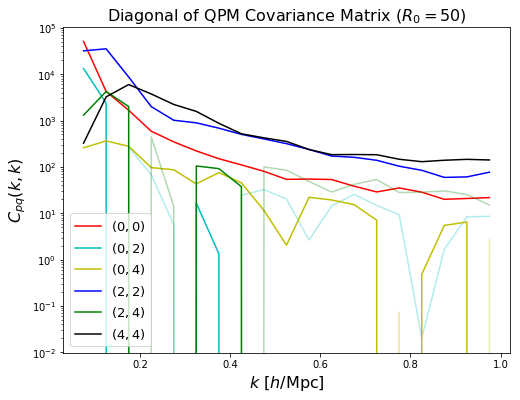

In [159]:
c=['r','c','y','b','g','k']
ci=0
plt.figure(figsize=(8,6))
for i in range(m):
    for j in range(i,m):
        col=c[ci]
        ci+=1
        plt.plot(k_bins,np.diag(qpm_cov[i*n:(i+1)*n,j*n:(j+1)*n]),label=r'$(%d,%d)$'%(i*2,j*2),c=col)
        plt.plot(k_bins,-np.diag(qpm_cov[i*n:(i+1)*n,j*n:(j+1)*n]),alpha=0.3,c=col)
plt.legend(fontsize=13)
plt.ylabel(r'$C_{pq}(k,k)$',fontsize=16)
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16)
plt.title(r'Diagonal of QPM Covariance Matrix ($R_0=50$)',fontsize=16);
plt.yscale('log');

#### Compare two diagonals

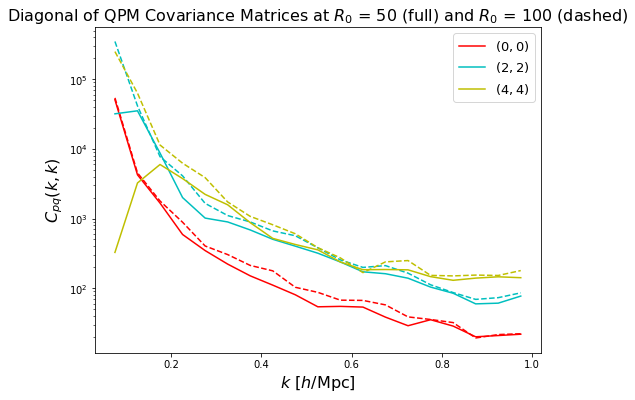

In [160]:
c=['r','c','y','b','g','k']
ci=0
plt.figure(figsize=(8,6))
for i in range(m):
        j=i
        col=c[ci]
        ci+=1
        plt.plot(k_bins,np.diag(qpm_cov[i*n:(i+1)*n,j*n:(j+1)*n]),label=r'$(%d,%d)$'%(i*2,j*2),c=col)
        plt.plot(k_bins,np.diag(qpm_cov100[i*n:(i+1)*n,j*n:(j+1)*n]),ls='--',c=col)
plt.legend(fontsize=13)
plt.ylabel(r'$C_{pq}(k,k)$',fontsize=16)
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16)
plt.title(r'Diagonal of QPM Covariance Matrices at $R_0$ = 50 (full) and $R_0$ = 100 (dashed)',fontsize=16);
plt.yscale('log');

### Compute inverse matrix (no Hartlap rescaling here)

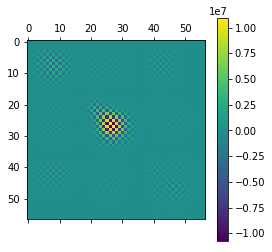

In [65]:
plt.matshow(np.linalg.inv(qpm_cov));plt.colorbar();

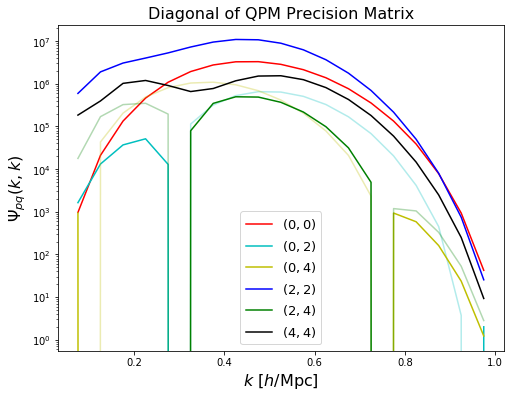

In [71]:
c=['r','c','y','b','g','k']
ci=0
inv_cov = np.linalg.inv(qpm_cov)
plt.figure(figsize=(8,6))
for i in range(m):
    for j in range(i,m):
        col=c[ci]
        ci+=1
        plt.plot(k_bins,np.diag(inv_cov[i*n:(i+1)*n,j*n:(j+1)*n]),label=r'$(%d,%d)$'%(i*2,j*2),c=col)
        plt.plot(k_bins,-np.diag(inv_cov[i*n:(i+1)*n,j*n:(j+1)*n]),alpha=0.3,c=col)
plt.legend(fontsize=13)
plt.ylabel(r'$\Psi_{pq}(k,k)$',fontsize=16)
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16)
plt.title(r'Diagonal of QPM Precision Matrix',fontsize=16);
plt.yscale('log');

In [867]:
gaussian_dat = np.load('gaussian_power_tot_50.npz')
gaussian_2pt = gaussian_dat.f.two_point
gaussian_3pt = gaussian_dat.f.three_point
gaussian_4pt = gaussian_dat.f.four_point
gaussian_tot = lambda alpha: gaussian_2pt*alpha**2.+gaussian_3pt*alpha+gaussian_4pt

In [868]:
gaussian_dat100 = np.load('gaussian_power_tot_100.npz')
gaussian_2pt100 = gaussian_dat100.f.two_point
gaussian_3pt100 = gaussian_dat100.f.three_point
gaussian_4pt100 = gaussian_dat100.f.four_point
gaussian_tot100 = lambda alpha: gaussian_2pt100*alpha**2.+gaussian_3pt100*alpha+gaussian_4pt100

In [869]:
g_inv=np.linalg.inv(gaussian_tot100(1.1))
chol_g = np.linalg.cholesky(g_inv)
disc = np.matmul(chol_g.T,np.matmul(qpm_cov100,chol_g))-np.eye(len(g_inv))

Text(0,0.5,'$k\\,\\,[h/\\mathrm{Mpc}]$')

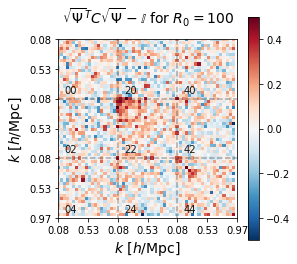

In [872]:
m=3
vmax=0.5
plt.matshow(disc,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.title(r'$\sqrt{\Psi}^TC\sqrt{\Psi}-\mathbb{I}$ for $R_0 = 100$',fontsize=14)
plt.gca().xaxis.tick_bottom()
for i in range(m-1):
        plt.hlines(nk*(i+1),0,nk*m,linestyles='--',alpha=0.3);
        plt.vlines(nk*(i+1),0,nk*m,linestyles='--',alpha=0.3);
for i in range(m):
    for j in range(m):
        plt.text((i+0.1)*nk,(j+0.9)*nk,'%d%d'%(2*i,2*j),alpha=0.9)
plt.colorbar();    
plt.ylim([m*nk,0])
plt.xlim([0,m*nk])
ticks = np.concatenate([["%.2f"%(min(k_med)),"%.2f"%(k_med[len(k_med)//2])] for _ in range(m)])
plt.xticks(np.arange(0,(nk+0.5)*m,nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
plt.yticks(np.arange(0,(nk+0.5)*m,nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]));
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=14)
plt.ylabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=14)

## Plot $C_{00}$ residual for $k>0.1$ at $\alpha=1.2$

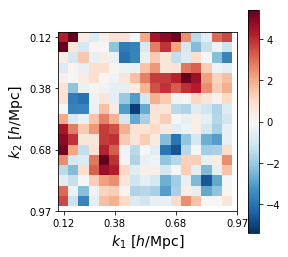

In [873]:
mat=((qpm_cov-gaussian_tot(1.2))*k_mat)[2:nk,2:nk]
vmax = np.percentile(mat.ravel(),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();
vals = np.linspace(0,nk-2,4,dtype='int')
plt.xticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.yticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.gca().xaxis.tick_bottom();
plt.xlabel(r'$k_1\,\,[h/\mathrm{Mpc}]$',fontsize=14)
plt.ylabel(r'$k_2\,\,[h/\mathrm{Mpc}]$',fontsize=14);

### Compare to true matrix with $p=q=0$

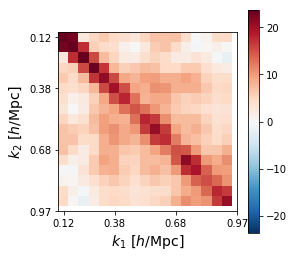

In [875]:
mat=(qpm_cov*k_mat)[2:nk,2:nk]
vmax = np.percentile(mat.ravel(),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();
vals = np.linspace(0,nk-2,4,dtype='int')
plt.xticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.yticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.gca().xaxis.tick_bottom();
plt.xlabel(r'$k_1\,\,[h/\mathrm{Mpc}]$',fontsize=14)
plt.ylabel(r'$k_2\,\,[h/\mathrm{Mpc}]$',fontsize=14);

### Visualize for all $\ell$

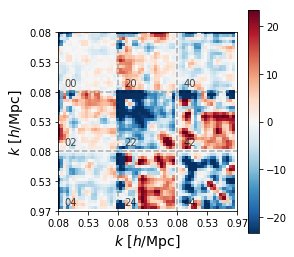

In [876]:
k_plotter(k_mat*(gaussian_tot(1.2)-qpm_cov),99.)

### Plot diagonals

R0=50: Full Lines, R0=100: Dashed Lines


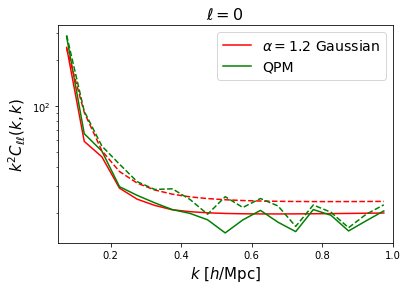

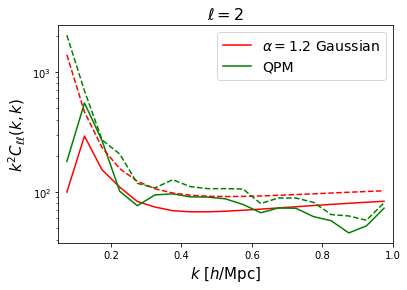

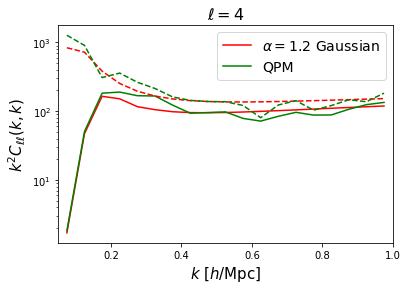

In [880]:
for i in range(m):
    plt.figure()
    plt.plot(k_bins,np.diag(k_mat*gaussian_tot(1.2)).reshape(m,n).T[:,i],label=r'$\alpha = 1.2$ Gaussian',c='r')
    plt.plot(k_bins,np.diag(k_mat*qpm_cov).reshape(m,n).T[:,i],label='QPM',c='g');
    plt.plot(k_bins,np.diag(k_mat*gaussian_tot100(1.2)).reshape(m,n).T[:,i],c='r',ls='--')
    plt.plot(k_bins,np.diag(k_mat*qpm_cov100).reshape(m,n).T[:,i],c='g',ls='--');
    plt.yscale('log')
    plt.xlim([0.05,1.])
    plt.legend(fontsize=14);
    plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=15)
    plt.ylabel(r'$k^2C_{\ell\ell}(k,k)$',fontsize=15)
    plt.title(r'$\ell = %d$'%(i*2),fontsize=16)
print("R0=50: Full Lines, R0=100: Dashed Lines")

# Scratch

In [269]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl2 = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl2(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # kaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

In [321]:
power_ravel = np.asarray([pp.T.reshape(-1,) for pp in all_power])

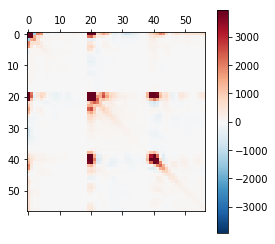

In [322]:
mat=np.cov(power_ravel.T)
vmax=np.percentile(mat,99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.colorbar();

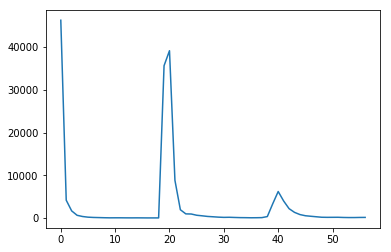

In [119]:
plt.plot(np.diag(mat));#plt.yscale('log');

In [118]:
theory_cov=np.load('theory_power_cov.npy')

In [61]:
plt.matshow(inv_theory);plt.colorbar()

NameError: name 'inv_theory' is not defined

In [803]:
inv_theory = np.linalg.inv(theory_cov)
sq_inv_th = np.linalg.cholesky(inv_theory)
disc = np.matmul(sq_inv_th.T,np.matmul(cov,sq_inv_th))

LinAlgError: Matrix is not positive definite

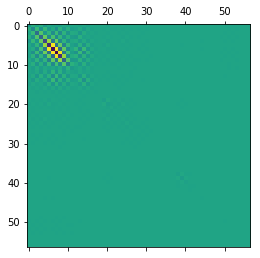

In [801]:
plt.matshow(inv_theory*mat)

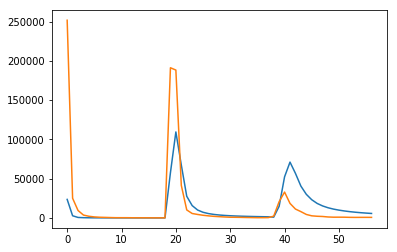

In [798]:
plt.plot(np.diag(theory_cov))
plt.plot(np.diag(mat)*5)

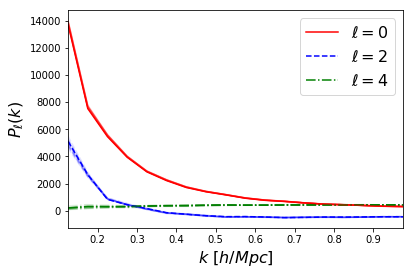

In [105]:
for i in range(n_mocks):
    if i==0:
        plt.plot(k_bins,all_power[i][:,0],label=r'$\ell=0$',c='r',ls='-')
        plt.plot(k_bins,all_power[i][:,1],label=r'$\ell=2$',c='b',ls='--')
        plt.plot(k_bins,all_power[i][:,2],label=r'$\ell=4$',c='g',ls='-.')
    else:
        plt.plot(k_bins,all_power[i][:,0],c='r',ls='-',alpha=0.1)
        plt.plot(k_bins,all_power[i][:,1],c='b',ls='--',alpha=0.1)
        plt.plot(k_bins,all_power[i][:,2],c='g',ls='-.',alpha=0.1)
plt.legend(fontsize=16);
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.125,0.975]);

In [93]:
all_power[0][0]

array([13715.95492505,  5109.8731135 ,   206.8363445 ])

In [26]:
power_estimate = (DD-2.*DR/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm

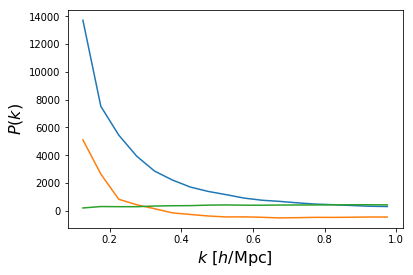

In [285]:
#plt.plot(k_bins,power_estimate)
plt.plot(k_bins,binned_power_estimate.reshape(-1,3))
#plt.yscale('log')
plt.ylabel(r'$P(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/$Mpc]',fontsize=16);

**Add simple CAMB model for comparison**

In [62]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # jaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

In [63]:
from scipy.integrate import quad

ell=0

#binned_power = []
true_binned_power = []
true_point_power = []

for i in range(len(all_k)):
    #binned_power.append(quad(lambda k: kaiser_power_model(k,2)*k,all_k[i,0],all_k[i,1])[0]/quad(lambda k: k,k_bins[i,0],k_bins[i,1])[0])
    true_binned_power.append(quad(lambda k: kaiser_power_model(k,0)*k**2.,all_k[i,0],all_k[i,1])[0]/quad(lambda k: k**2.,all_k[i,0],all_k[i,1])[0])
    true_point_power.append(kaiser_power_model(np.mean([all_k[i,0],all_k[i,1]]),0))

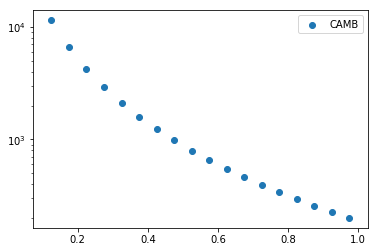

In [72]:
kk = np.mean(all_k,axis=1)
plt.scatter(kk,power_estimate,label='RascalC')
plt.scatter(kk,true_point_power,label='CAMB');
plt.legend();plt.yscale('log');

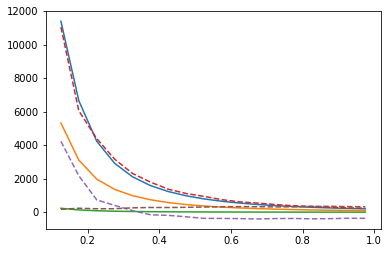

In [78]:
for ell in [0,2,4]:
    plt.plot(kk,[kaiser_power_model(k,ell) for k in kk])
plt.plot(kk,power_estimate.reshape(-1,3)*0.8,ls='--')

#### Compare binned vs unbinned

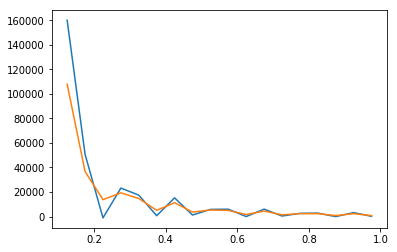

In [105]:
plt.plot(k_bins,DD)
plt.plot(k_bins,DD_binned)

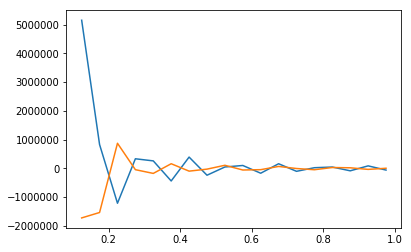

In [107]:
plt.plot(k_bins,DR)
plt.plot(k_bins,DR_binned)